<a href="https://colab.research.google.com/github/alimomennasab/ASL-Translator/blob/main/CS4200CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Data Preprocessing

In [2]:
# import os
# import cv2
# import numpy as np
# import shutil
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm
# from pathlib import Path

# IMG_SIZE = 256
# FRAME_SKIP = 2
# dataset_dir = Path("/content/drive/MyDrive/WLASL/WLASL100_train_augmented")
# stacked_dataset_dir = Path("/content/drive/MyDrive/WLASL/WLASL100_train_augmented_stacked")


# # Clear stacked dataset directory
# if os.path.exists(stacked_dataset_dir):
#     for sub in os.listdir(stacked_dataset_dir):
#         path = os.path.join(stacked_dataset_dir, sub)
#         if os.path.isdir(path):
#             shutil.rmtree(path)
#         else:
#             os.remove(path)
# else:
#     os.makedirs(stacked_dataset_dir)
# print("Cleared folder")

# def stack_frames_max(frames_bgr, resize=(IMG_SIZE, IMG_SIZE), frame_skip=FRAME_SKIP):
#     if not frames_bgr:
#         return None
#     frames_bgr = frames_bgr[::max(1, frame_skip)]
#     acc = None
#     for f in frames_bgr:
#         f = cv2.resize(f, resize)
#         if acc is None:
#             acc = f.astype(np.float32)
#         else:
#             acc = np.maximum(acc, f.astype(np.float32))
#     return acc.astype(np.uint8)

# def process_video(video_path, class_dir_name):
#     save_dir = stacked_dataset_dir / class_dir_name
#     save_dir.mkdir(parents=True, exist_ok=True)
#     out_path = save_dir / f"{video_path.stem}_stacked.png"

#     cap = cv2.VideoCapture(str(video_path))
#     if not cap.isOpened():
#         error_msg = f"Could not open video: {video_path}\n"
#         if not video_path.exists():
#             error_msg += f"    - File does not exist."
#         elif not video_path.is_file():
#             error_msg += f"    - Path is not a file."
#         elif os.path.getsize(video_path) == 0:
#             error_msg += f"    - File is empty (0 bytes)."
#         else:
#             error_msg += (f"    - Possible causes:\n"
#                           f"      - Codec not supported by OpenCV in this environment\n"
#                           f"      - Corrupt video file or unrecognized format\n"
#                           f"      - Permissions issue preventing access to the file")
#         return error_msg

#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#     if frame_count == 0:
#         cap.release()
#         return f"No frames found in: {video_path}\n    Metadata: {frame_count} frames, {fps:.2f} FPS, {width}x{height}\n    Possible causes:\n      - Video might be empty or corrupted even if it could be opened.\n      - Codec not supported by OpenCV in this environment."

#     frames = []
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frames.append(frame)
#     cap.release()

#     if len(frames) == 0:
#         return (f"No frames read from {video_path}\n"
#                 f"    Metadata: {frame_count} frames, {fps:.2f} FPS, {width}x{height}\n"
#                 f"    Possible causes:\n"
#                 f"      - Codec not supported by OpenCV in this environment\n"
#                 f"      - Corrupt video file or 0-byte content\n"
#                 f"      - File path issue or permission denied")
#     elif len(frames) < frame_count * 0.1:
#         print(f"Warning: Only read {len(frames)} / {frame_count} frames from {video_path} (partial read)")

#     stacked_img = stack_frames_max(frames)
#     if stacked_img is None:
#         return f"Stacking failed for {video_path}"

#     success = cv2.imwrite(str(out_path), stacked_img)
#     if not success:
#         return f"Failed to write stacked image: {out_path}"

#     return None  # success

# # Collect all videos
# video_tasks = []
# for class_dir in dataset_dir.iterdir():
#     if not class_dir.is_dir():
#         continue
#     for video_path in class_dir.glob("*.mp4"):
#         video_tasks.append((video_path, class_dir.name))

# print(f"Found {len(video_tasks)} total videos")

# # Parallel ThreadPoolExecutor
# max_workers = os.cpu_count()
# print(f"Using {max_workers} workers")
# errors = []
# with ThreadPoolExecutor(max_workers=max_workers) as executor:
#     futures = [executor.submit(process_video, v, c) for v, c in video_tasks]
#     for f in tqdm(as_completed(futures), total=len(futures), desc="Stacking videos"):
#         err = f.result()
#         if err:
#             errors.append(err)

# print(f"Completed. {len(errors)} videos failed.")

# if errors:
#     print("\nList of all failed videos:")
#     for e in errors:
#         print(e)

Cleared folder
Found 2915 total videos
Using 2 workers


Stacking videos: 100%|██████████| 2915/2915 [14:19<00:00,  3.39it/s]

Completed. 0 videos failed.


In [4]:

# if a label folder has under 5 videos, add to ignore list
import os

dataset_dir = "/content/drive/MyDrive/WLASL/WLASL100_train_augmented_stacked"
ignore_labels = []
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if len(os.listdir(label_dir)) < 5:
        ignore_labels.append(label)

print(f"Ignored labels: {sorted(ignore_labels)}")
# Ignored labels: ['know', 'language', 'like', 'lose', 'make', 'match', 'office', 'old', 'orange', 'order', 'paint', 'pants', 'rabbit', 'read']

Ignored labels: []


Data loading

In [2]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path

DATASET_DIR = "/content/drive/MyDrive/WLASL/WLASL100_train_augmented_stacked"
IMG_SIZE = 256
BATCH_SIZE = 32

# ignore label folders with under 5 videos
#ignored_labels = ['know', 'language', 'like', 'lose', 'make', 'match', 'office', 'old', 'orange', 'order', 'paint', 'pants', 'rabbit', 'read']
ignored_labels = []

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Dataset for loading png overlay files
class OverlayDataset(Dataset):
    def __init__(self, root_dir, transform=None, ignore_labels=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.ignore_labels = set(ignore_labels or [])
        self.samples = []

        if self.ignore_labels:
            print("Ignored labels:", sorted(list(self.ignore_labels)))

        # Walk through every subfolder and collect overlay PNGs
        for class_dir in sorted(self.root_dir.iterdir()):
            label = class_dir.name

            # Skip ignored labels
            if label in self.ignore_labels:
                continue

            for img_path in class_dir.glob("*.png"):
                self.samples.append((img_path, label))

        # Build class index mapping
        self.class_names = sorted(list({label for _, label in self.samples}))
        self.class_to_idx = {c: i for i, c in enumerate(self.class_names)}

        print(f"Found {len(self.samples)} overlay images across {len(self.class_names)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]


# Image transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Load dataset
print("Creating dataset")
print(f"There are {len(os.listdir(DATASET_DIR))} label folders in {DATASET_DIR}. We will ignore {len(ignored_labels)} of these")
full_ds = OverlayDataset(DATASET_DIR, transform=transform, ignore_labels=ignored_labels)

# Train/Val split
val_split = 0.2
val_size = int(len(full_ds) * val_split)
train_size = len(full_ds) - val_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

print("Creating dataloaders")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = full_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names[:10], "...")
print("num_classes =", num_classes)

Using device: cuda
Creating dataset
There are 100 label folders in /content/drive/MyDrive/WLASL/WLASL100_train_augmented_stacked. We will ignore 0 of these
Found 2915 overlay images across 100 classes
Creating dataloaders
Classes: ['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black'] ...
num_classes = 100


Model training

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]
Epoch 1/8: 100%|██████████| 73/73 [07:46<00:00,  6.39s/it, acc=16.4, loss=3.64]


Epoch 1: Train Acc=16.42% | Val Acc=36.54%


Epoch 2/8: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s, acc=67.6, loss=1.91]


Epoch 2: Train Acc=67.58% | Val Acc=75.47%


Epoch 3/8: 100%|██████████| 73/73 [00:28<00:00,  2.55it/s, acc=95.1, loss=0.418]


Epoch 3: Train Acc=95.07% | Val Acc=91.60%


Epoch 4/8: 100%|██████████| 73/73 [00:28<00:00,  2.54it/s, acc=99.4, loss=0.129]


Epoch 4: Train Acc=99.40% | Val Acc=95.71%


Epoch 5/8: 100%|██████████| 73/73 [00:29<00:00,  2.51it/s, acc=99.7, loss=0.0543]


Epoch 5: Train Acc=99.74% | Val Acc=96.74%


Epoch 6/8: 100%|██████████| 73/73 [00:28<00:00,  2.54it/s, acc=99.8, loss=0.0279]


Epoch 6: Train Acc=99.79% | Val Acc=97.26%


Epoch 7/8: 100%|██████████| 73/73 [00:28<00:00,  2.54it/s, acc=99.9, loss=0.0208]


Epoch 7: Train Acc=99.91% | Val Acc=96.74%


Epoch 8/8: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s, acc=99.8, loss=0.0192]


Epoch 8: Train Acc=99.83% | Val Acc=97.08%


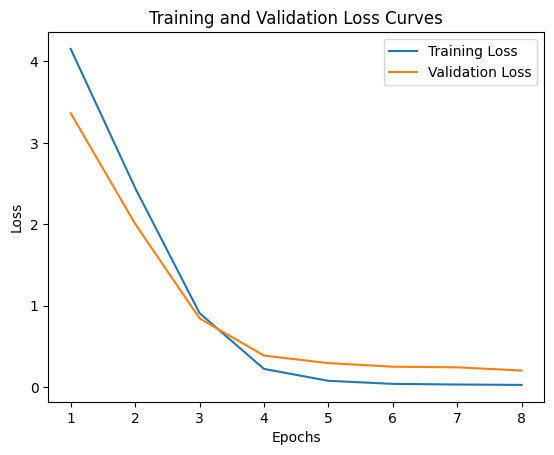

In [3]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from tqdm import tqdm

def plot_losses(train_losses: list, val_losses: list):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


num_classes = len(class_names)

# Load pretrained ResNet50
model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 8

# Training loop
model.train()
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_epoch_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()
    val_losses.append(val_epoch_loss / len(val_loader))

    val_acc = 100. * val_correct / val_total
    print(f"Epoch {epoch+1}: Train Acc={100.*correct/total:.2f}% | Val Acc={val_acc:.2f}%")

plot_losses(train_losses, val_losses)

Save Models/Labels

In [4]:
import json
from google.colab import drive

drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/asl_overlay_resnet18.pt"
LABELS_PATH = "/content/drive/MyDrive/asl_overlay_labels.json"

torch.save(model.state_dict(), MODEL_PATH)

with open(LABELS_PATH, "w") as f:
    json.dump(class_names, f)

print("Model saved to:", MODEL_PATH)
print("Labels saved to:", LABELS_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/asl_overlay_resnet18.pt
Labels saved to: /content/drive/MyDrive/asl_overlay_labels.json


Testing model

In [6]:
import cv2
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


IMG_SIZE = 256
CROP_AMOUNT = 75 # pixels

# Test dataset augmentations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def stack_frames_max(frames_bgr, resize=(IMG_SIZE, IMG_SIZE), frame_skip=2):
    if not frames_bgr:
        return None
    frames_bgr = frames_bgr[::max(1, frame_skip)]
    acc = None
    for f in frames_bgr:
        f = cv2.resize(f, resize)
        if acc is None:
            acc = f.astype(np.float32)
        else:
            acc = np.maximum(acc, f.astype(np.float32))
    return acc.astype(np.uint8)

def crop_border_frames(frames, crop_amount=75):
    h, w = frames[0].shape[:2]
    return [f[:, crop_amount:w - crop_amount] for f in frames]

# Test dataset that only uses words the model trained on
class TestDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None, valid_labels=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.valid_labels = set(valid_labels or [])
        self.samples = []

        for class_dir in sorted(self.root_dir.iterdir()):
            # only keep labels that were in training
            if not class_dir.is_dir() or class_dir.name not in self.valid_labels:
                continue
            for video_path in class_dir.glob("*.mp4"):
                self.samples.append((video_path, class_dir.name))

        print(f"Found {len(self.samples)} videos across {len(set(l for _, l in self.samples))} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = []
        cap = cv2.VideoCapture(str(video_path))
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()

        # cropping
        frames = crop_border_frames(frames, crop_amount=CROP_AMOUNT)
        stacked_img = stack_frames_max(frames, resize=(IMG_SIZE, IMG_SIZE), frame_skip=FRAME_SKIP)

        # stacking
        stacked_img = stack_frames_max(frames)
        img = Image.fromarray(cv2.cvtColor(stacked_img, cv2.COLOR_BGR2RGB))
        if self.transform:
            img = self.transform(img)
        return img, self.class_to_idx[label]


# Config
FRAME_SKIP = 2
ignored_labels = [] #['know', 'language', 'like', 'lose', 'make', 'match', 'office', 'old', 'orange', 'order', 'paint', 'pants', 'rabbit', 'read']
test_dir = "/content/drive/MyDrive/WLASL/WLASL100_test"
LABELS_PATH = "/content/drive/MyDrive/asl_overlay_labels.json"
MODEL_PATH = "/content/drive/MyDrive/asl_overlay_resnet18.pt"

# Build labels list
with open(LABELS_PATH, "r") as f:
    class_names = json.load(f)
class_to_idx = {c: i for i, c in enumerate(class_names)}
train_labels = set(class_names)
test_labels = {d.name for d in Path(test_dir).iterdir() if d.is_dir()}
in_train_and_test = sorted(list(train_labels & test_labels - set(ignored_labels)))
print(f"Testing on {len(in_train_and_test)} shared classes between training & testing")

# Initialize dataset, dataloader, and model
test_dataset = TestDataset(test_dir, class_to_idx, transform=transform, valid_labels=in_train_and_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# Testing
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute & display metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# cm = confusion_matrix(all_labels, all_preds)
# print("Confusion Matrix:")
# print(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(xticks_rotation='vertical', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()

Testing on 88 shared classes between training & testing
Found 98 videos across 88 classes


Testing: 100%|██████████| 4/4 [00:56<00:00, 14.21s/it]

Test Accuracy: 24.49%


In [ ]:
# train_labels = set(class_names)
# test_labels = {d.name for d in Path(test_dir).iterdir() if d.is_dir()}

# missing_in_test = train_labels - test_labels
# extra_in_test = test_labels - train_labels
# in_train_and_test = train_labels & test_labels

# print(f"Trained classes not found in test: {len(missing_in_test)}")
# print(sorted(list(missing_in_test))[:20])

# print(f"Extra test classes not seen during training: {len(extra_in_test)}")
# print(sorted(list(extra_in_test))[:20])

# print(f"Shared train and test classes: {len(in_train_and_test)}")
# print(sorted(list(in_train_and_test)))


Trained classes not found in test: 4
['book', 'children', 'clock', 'divorce']
Extra test classes not seen during training: 127
['kiss', 'knife', 'know', 'language', 'last', 'late', 'laugh', 'law', 'learn', 'leave', 'letter', 'light', 'like', 'live', 'lose', 'make', 'match', 'mean', 'meat', 'meet']
Shared train and test classes: 167
['about', 'accident', 'africa', 'again', 'all', 'always', 'animal', 'apple', 'approve', 'argue', 'arrive', 'baby', 'back', 'backpack', 'bad', 'bake', 'balance', 'ball', 'banana', 'bar', 'basketball', 'bath', 'bathroom', 'beard', 'because', 'bed', 'before', 'behind', 'bird', 'birthday', 'black', 'blanket', 'blue', 'bowling', 'boy', 'bring', 'brother', 'brown', 'business', 'but', 'buy', 'call', 'can', 'candy', 'careful', 'cat', 'catch', 'center', 'cereal', 'chair', 'champion', 'change', 'chat', 'cheat', 'check', 'cheese', 'christmas', 'city', 'class', 'close', 'clothes', 'coffee', 'cold', 'college', 'color', 'computer', 'convince', 'cook', 'cool', 'copy', 'cor

### Setup Webcam Access (Cell A)

This cell injects JavaScript code into the browser to set up webcam access. It creates video and canvas elements, requests user media (webcam), and defines JavaScript functions to capture frames (`getFrame()`) and clean up (`cleanup()`). It then waits for `getFrame()` to be available before proceeding.

In [ ]:
# ==== Cell A: Inject & execute JS in browser, wait until getFrame() is available ====
from google.colab import output as colab_output
import time, json

setup_js = r"""
(async () => {
  try {
    const video = document.createElement('video');
    video.setAttribute('id','asl_cam');
    video.style.display = 'block';
    video.style.maxWidth = '640px';
    video.style.border = '1px solid #ccc';
    document.body.appendChild(video);

    const stream = await navigator.mediaDevices.getUserMedia({video:{facingMode:"user"}, audio:false});
    video.srcObject = stream;
    await video.play();

    const canvas = document.createElement('canvas');
    canvas.setAttribute('id','asl_canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = video.videoWidth || 640;
    canvas.height = video.videoHeight || 480;

    window.asl_video = video;
    window.asl_stream = stream;
    window.asl_canvas = canvas;
    window.asl_ctx = ctx;

    // define getFrame (returns dataURL)
    window.getFrame = async function() {
      if (!window.asl_video) return null;
      window.asl_ctx.drawImage(window.asl_video, 0, 0, window.asl_canvas.width, window.asl_canvas.height);
      return window.asl_canvas.toDataURL('image/jpeg', 0.85);
    };

    // define cleanup
    window.cleanup = async function() {
      if (window.asl_stream) {
        window.asl_stream.getTracks().forEach(t => t.stop());
      }
      // remove video if present
      try { if (window.asl_video && window.asl_video.parentElement) window.asl_video.parentElement.removeChild(window.asl_video); } catch(e){}
      delete window.getFrame;
      delete window.cleanup;
      return true;
    };

    return {"ok": true};
  } catch(err) {
    return {"error": String(err)};
  }
})();
"""

print("Injecting webcam JS into browser — you will be prompted to allow camera access.")
res = colab_output.eval_js(setup_js)
if isinstance(res, dict) and res.get("error"):
    raise RuntimeError("JS setup returned error: " + res["error"])
# Poll until getFrame is available (timeout)
timeout = 10.0
start = time.time()
while True:
    try:
        ok = colab_output.eval_js("typeof window.getFrame === 'function'")
    except Exception:
        ok = False
    if ok:
        print("getFrame() is available in the browser.")
        break
    if time.time() - start > timeout:
        raise RuntimeError("Timed out waiting for getFrame() to be defined in browser. Try refreshing the page and running this cell again.")
    time.sleep(0.2)

print("JS webcam helper installed. Now run the main Python loop cell (Cell B).")

### Live ASL Recognition Loop (Cell B)

This cell contains the main loop for live ASL recognition using the webcam. It continuously captures frames from the browser using the `getFrame()` JavaScript function, processes them to create an overlay image by stacking frames, uses the trained model to predict the ASL sign, and displays the prediction and a running transcript.

In [ ]:
# ==== Cell B: Live loop — call getFrame(), maintain 1.5s buffer, stack frames, predict, transcript ====
import time, base64
from collections import deque
import json
from IPython.display import clear_output, display
from google.colab import output as colab_output

import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import models, transforms

# ----------------------- User config (edit if needed) -----------------------
MODEL_PATH = "/content/asl_overlay_resnet18.pt"
LABELS_PATH = "/content/asl_overlay_labels.json"

IMG_SIZE = 256
FRAME_SKIP = 2          # subsample frames when stacking
BUFFER_SECONDS = 1.5    # rolling window size in seconds
CONF_THRESH = 0.60
SHOW_OVERLAY_PREVIEW = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ---------------------------------------------------------------------------

# Load labels + model
with open(LABELS_PATH, "r") as f:
    class_names = json.load(f)
num_classes = len(class_names)

model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval().to(DEVICE)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def stack_frames_max(frames_bgr, resize=(IMG_SIZE, IMG_SIZE), frame_skip=FRAME_SKIP):
    if not frames_bgr:
        return None
    frames_bgr = frames_bgr[::max(1, frame_skip)]
    acc = None
    for f in frames_bgr:
        f = cv2.resize(f, resize)
        if acc is None:
            acc = f.astype(np.float32)
        else:
            acc = np.maximum(acc, f.astype(np.float32))
    return acc.astype(np.uint8)

def predict_stacked_bgr(overlay_bgr):
    rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE))
    x = preprocess(rgb).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = torch.softmax(model(x), dim=1)[0].cpu().numpy()
    idx = int(np.argmax(probs))
    return class_names[idx], float(probs[idx])

# ----------------------- Live capture loop -----------------------
buffer = deque()
transcript = []

print("Live ASL recognition starting. Press Ctrl+C in the cell output to stop.")
try:
    while True:
        # Request current frame from browser helper
        # Use a small retry loop for transient message errors
        data_url = None
        for _ in range(3):
            try:
                data_url = colab_output.eval_js("getFrame()")
                break
            except Exception:
                time.sleep(0.05)
                continue
        if data_url is None:
            # If still None, try again
            time.sleep(0.01)
            continue

        # decode data url into BGR frame
        header, encoded = data_url.split(",", 1)
        frame = np.frombuffer(base64.b64decode(encoded), dtype=np.uint8)
        frame = cv2.imdecode(frame, cv2.IMREAD_COLOR)  # BGR

        now = time.time()
        buffer.append((now, frame))

        # trim old frames
        while buffer and (now - buffer[0][0]) > BUFFER_SECONDS:
            buffer.popleft()

        # if buffer roughly full -> process
        if buffer and (buffer[-1][0] - buffer[0][0]) >= (BUFFER_SECONDS * 0.95):
            frames_only = [f for (_, f) in buffer]
            overlay = stack_frames_max(frames_only)

            if overlay is not None:
                label, conf = predict_stacked_bgr(overlay)
                if conf >= CONF_THRESH:
                    transcript.append(label)
                else:
                    transcript.append("[?]")

                # show stacked preview if desired
                if SHOW_OVERLAY_PREVIEW:
                    preview = overlay.copy()
                    cv2.putText(preview, f"{label} ({conf:.2f})", (10, 28),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
                    rgb = cv2.cvtColor(preview, cv2.COLOR_BGR2RGB)
                    clear_output(wait=True)
                    display(Image.fromarray(rgb))
                else:
                    clear_output(wait=True)

                # print running transcript
                print("Live ASL recognition (Stop the cell to end)\n")
                print("Transcript:\n", " ".join(transcript))

            # reset buffer to form next 1.5s segment
            buffer.clear()

        # small sleep
        time.sleep(0.01)

except KeyboardInterrupt:
    pass
finally:
    # request browser cleanup (stop camera)
    try:
        colab_output.eval_js("cleanup()")
    except Exception:
        pass
    print("\n Stopped. Final transcript:")
    print(" ".join(transcript))